---
title: "Python exercise: Pile driveability"
author: "Kevin Duffy"
execute:
  echo: true
<!-- bibliography: ../bibliography.bib -->
---

In this, we're going to make our own driveability model. To do so, we're just going to consider a circular closed-ended concrete pile

Note that downwards penetration of the pile is negative.


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

## Spring dashpots
Spring dashpots are the cornerstone of any driveabilility analysis and represent the resistance contribution of the soil

It first consists of a **static component**. This static component describes the soil resistance: comprising of which is a spring with a certain stiffness `k`.  

This spring has a certain `quake`, which describes the displacement need to go from an elastic to plastic response. This quake is typically 2.5mm for the shaft resistance. For the base resistance, this is a bit more complicated and depends on the stiffness of the soil underneath the pile base. Generally $D/60$ can be taken for loose or soft soils and $D/120$ for dense or stiff soils.

There is also a **dynamic component**, known as a dashpot. 

In [2]:
class SpringDashpot:
    def __init__(self, damping, max_force, quake):
        self.k = max_force / quake if quake > 0 else 1e6  # avoid div by zero [Nm]
        self.quake = quake        # [m]
        self.Js = damping         # Smith damping factor [s/m]
        self.max_force = max_force# Soil capacity [N]
        self.u_perm = 0.0         # Placeholder for recording the amount of maximum displacemtn
        self.R_total = 0.0

    def compute_force(self, u_rel, v_rel):
        delta_u = u_rel - self.u_perm
        sign = np.sign(delta_u)
        abs_du = abs(delta_u)

        if abs_du <= self.quake:
            R_static = self.k * delta_u
        else:
            R_static = self.max_force * sign
            self.u_perm += (abs_du - self.quake) * sign

        R_damp = self.Js * abs(R_static) * v_rel
        self.R_total = R_static + R_damp
        return self.R_total

## Soil profile
Let's now define our soil profile and assign each layer some properties relevant to the driveability study. This is going to be done using the `SoilProfile` class, which consists of one or more `SoilLayer`s. 

Keep in mind the damping and quake parameters are different for the pile base and piel shaft

In [3]:
class SoilLayer:
    def __init__(self, top, bottom, qb_max, qs_max, shaft_damping, base_damping, shaft_quake, base_quake):
        self.top = top
        self.bottom = bottom 
        self.qb_max = qb_max        # Maximum base stress [Pa]
        self.qs_max = qs_max        # Maximum shear stress [Pa]
        self.shaft_damping = shaft_damping      # Smith damping coefficient[s/m]
        self.base_damping = base_damping        # Smith damping coefficient[s/m]
        self.shaft_quake = shaft_quake          # [m]
        self.base_quake = base_quake            # [m]

    def contains(self, z):
        return self.bottom <= z < self.top

class SoilProfile:
    def __init__(self, layers):
        self.layers = layers  # List of SoilLayer objects

    def get_layer_at_depth(self, z):
        for layer in self.layers:
            if layer.contains(z):
                return layer
        return SoilLayer(top=1e6, bottom=-1e6, qb_max=0.0, qs_max=0.0, shaft_damping=0.0, base_damping=0.0, 
                         shaft_quake=1e-6, base_quake=1e-6) # No soil present (e.g. above ground surface)
 

We'll start simple here: let's define a two layered soil profile, with loose and dense sand. This will take some typical values in sand for the Smith damping factor (=0.16 s/m) `damping` and shaft quakes


Therefore: **REMOVED AND PUT DOWN BELOW**

## Define hammer
The hammer also has a cushion, with also has a `SpringDashpot` associated with it

In [4]:
class HAMMER:
    def __init__(self, mass, efficiency, E_rated, cushion_stiffness, cushion_damping, cushion_quake):
        self.mass = mass              # [kg]
        self.efficiency = efficiency  # [-]
        self.E_rated = E_rated        # [Nm]
        self.k_cushion = SpringDashpot(cushion_damping, E_rated / cushion_quake, cushion_quake)

    def impact_velocity(self, pile_mass):
        return -np.sqrt(2 * self.efficiency * self.E_rated / (pile_mass + self.mass))

    def reset(self, v0=0.0):
        self.k_cushion.u_perm = 0.0
        self.u = 0.0
        self.v = v0
    

In [5]:
# Define hammer (Junttan HHK3a)
hammer = HAMMER(mass=3000,   # kg
                efficiency=0.8,  # energy efficiency
                E_rated=35000, # J [Nm]
                cushion_stiffness=5e6, 
                cushion_damping=0.2, 
                cushion_quake=0.0025)

## Define our pile

We also need to define the number of increments `n_increments`. There's no fixed number for this, depends on how long it takes for the code


In [11]:
class Pile:
    def __init__(self, length, diameter, bottom_elevation, n_increments, 
                 youngs_modulus, damping_ratio, material_density,
                 soil_profile: SoilProfile):
        """ 
        where: 
            youngs_modulus: [Pa]
            damping ratio: [-]
            material density: [kg/m3]
        """
        self.length = length     # [m]
        self.diameter = diameter # [m]
        self.area = np.pi * (diameter/2)**2  # Cross-section area [m2]
        self.n = n_increments
        self.dz = length / n_increments
        self.total_mass = self.area * length * material_density
        self.mass_per_increment = self.total_mass / self.n
        self.m = np.ones(self.n) * self.mass_per_increment

        self.k_axial = (youngs_modulus * self.area) / self.dz  # Axial stiffness [Nm]
        self.c_axial = 2 * damping_ratio * np.sqrt(self.k_axial * self.mass_per_increment)

        self.u = np.zeros(self.n)
        self.v = np.zeros(self.n)
        self.a = np.zeros(self.n)

        self.segment_elevations = [bottom_elevation + (i+0.5)*self.dz for i in range(self.n)][::-1]
        self.assign_soil_springs(soil_profile)

        self.history = {"time": [], "top_disp": [], "top_vel": [], "top_acc": [], "tip_disp": [], "tip_vel": []}
        self.blow_depths = []
        self.blow_histories = []

    def assign_soil_springs(self, soil_profile):
        self.shaft_springs = []
        for z in self.segment_elevations:
            layer = soil_profile.get_layer_at_depth(z)
            Qs_max = layer.qs_max * (np.pi * self.diameter * self.dz)
            self.shaft_springs.append(SpringDashpot(
                damping=layer.shaft_damping,
                max_force=Qs_max,
                quake=layer.shaft_quake))
        # Assign spring at pile base
        base_layer = soil_profile.get_layer_at_depth(self.segment_elevations[-1])
        Qb_max = layer.qb_max * self.area
        self.base_spring = SpringDashpot(
            damping=base_layer.base_damping,
            max_force=Qb_max,
            quake=base_layer.base_quake
        )

    def compute_internal_forces(self):
        #Internal springs between pile elemenets
        F_internal = np.zeros(self.n)
        for i in range(1,self.n):
            du = self.u[i]-self.u[i-1]
            dv = self.v[i]-self.v[i-1]
            F = self.k_axial*du + self.c_axial*dv
            F_internal[i] += F
            F_internal[i-1] -= F
        return F_internal

    def compute_shaft_resistances(self):
        return np.array([self.shaft_springs[i].compute_force(self.u[i], self.v[i]) for i in range(self.n)])

    def compute_base_resistances(self):
        return self.base_spring.compute_force(self.u[-1], self.v[-1])


## Simulate

In [18]:
def reset_springs(pile):
    for spring in pile.shaft_springs:
        spring.u_perm = 0.0
    pile.base_spring.u_perm = 0.0

def step_dynamics(pile, hammer, dt):
    F_int = pile.compute_internal_forces()
    R_shaft = pile.compute_shaft_resistances()
    R_base = pile.compute_base_resistances()
    F_shifted = np.append(F_int[1:], R_base)

    pile.a = (-F_int - pile.m*9.81 + R_shaft + F_shifted)/pile.m
    pile.v += pile.a*dt
    pile.u += pile.v*dt  

    if hammer:
        du = hammer.u - pile.u[0]
        dv = hammer.v - pile.v[0]
        Fcushion = hammer.k_cushion.compute_force(du, dv)
        a_hammer = (-Fcushion - hammer.mass*9.81)/hammer.mass
        hammer.v += a_hammer*dt
        hammer.u += hammer.v*dt
        pile.a[0] += Fcushion/pile.m[0]
        pile.v[0] += (Fcushion/pile.m[0])*dt
        pile.u[0] += pile.v[0]*dt

    t_now = pile.history["time"][-1] + dt if pile.history["time"] else 0
    pile.history["time"].append(t_now)
    pile.history["top_disp"].append(pile.u[0])
    pile.history["top_vel"].append(pile.v[0])
    pile.history["top_acc"].append(pile.a[0])
    pile.history["tip_disp"].append(pile.u[-1])
    pile.history["tip_vel"].append(pile.v[-1])

def simulate_drive(pile, hammer, n_blows, dt, t_per_blow, rest_time):
    for blow in range(n_blows):
        print(f"Blow {blow} of {n_blows}")
        blow_time, blow_force = [], []
        reset_springs(pile)
        hammer.reset(v0=hammer.impact_velocity(pile.total_mass))

        steps = int(t_per_blow/dt)
        for _ in range(steps):
            step_dynamics(pile, hammer, dt)
            blow_time.append(pile.history["time"][-1])
            F_top = pile.k_axial*(pile.u[1]-pile.u[0]) + pile.c_axial*(pile.v[1]-pile.v[0])
            blow_force.append(F_top)

        pile.blow_depths.append(pile.segment_elevations[-1]+pile.u[-1])
        pile.blow_histories.append({"time":np.array(blow_time)-blow_time[0], "force":np.array(blow_force)})

        # rest
        for _ in range(int(rest_time/dt)):
            step_dynamics(pile, hammer=None, dt=dt)


## Plots

In [19]:
def plot_response(pile):
    t = pile.history["time"]
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.plot(t, pile.history["top_disp"], label="Top disp")
    plt.plot(t, pile.history["tip_disp"], label="Tip disp")
    plt.ylabel("Displacement [m]"); plt.legend(); plt.grid()
    plt.subplot(2,1,2)
    plt.plot(t, pile.history["top_vel"], label="Top vel")
    plt.plot(t, pile.history["tip_vel"], label="Tip vel")
    plt.ylabel("Velocity [m/s]"); plt.xlabel("Time [s]"); plt.legend(); plt.grid()
    plt.tight_layout(); plt.show()

def plot_blow_counts(pile):
    plt.figure(figsize=(5,6))
    plt.plot(np.arange(1,len(pile.blow_depths)+1), pile.blow_depths, marker="o")
    plt.xlabel("Blow count"); plt.ylabel("Penetration depth [m]"); plt.grid(); plt.show()

def plot_blow_forces(pile, n_to_plot=None):
    if n_to_plot is None: n_to_plot = len(pile.blow_histories)
    plt.figure(figsize=(8,5))
    for i in range(n_to_plot):
        data = pile.blow_histories[i]
        plt.plot(data["time"]*1e3, data["force"]*1e-3, label=f"Blow {i+1}")
    plt.xlabel("Time after blow [ms]"); plt.ylabel("Force [kN]"); plt.grid(); plt.legend(); plt.show()


Blow 0 of 10


C:\Users\kduffy\AppData\Local\Temp\ipykernel_23544\2221583158.py:56: RuntimeWarning: overflow encountered in scalar add
  F = self.k_axial*du + self.c_axial*dv
C:\Users\kduffy\AppData\Local\Temp\ipykernel_23544\1156265068.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  R_damp = self.Js * abs(R_static) * v_rel
C:\Users\kduffy\AppData\Local\Temp\ipykernel_23544\1559313011.py:12: RuntimeWarning: invalid value encountered in add
  pile.a = (-F_int - pile.m*9.81 + R_shaft + F_shifted)/pile.m


Blow 1 of 10
Blow 2 of 10
Blow 3 of 10
Blow 4 of 10
Blow 5 of 10
Blow 6 of 10
Blow 7 of 10
Blow 8 of 10
Blow 9 of 10


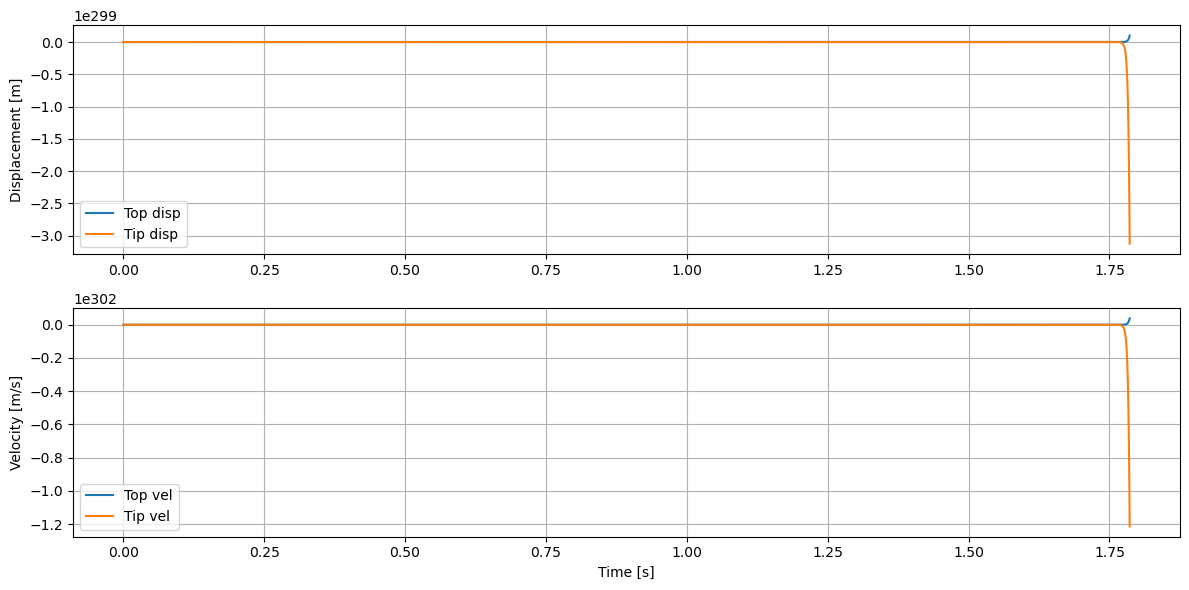

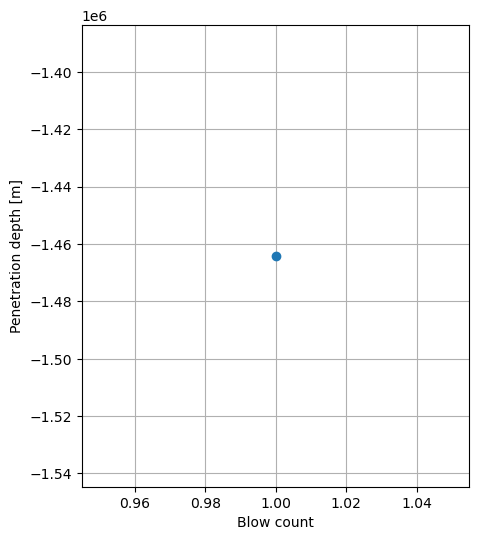

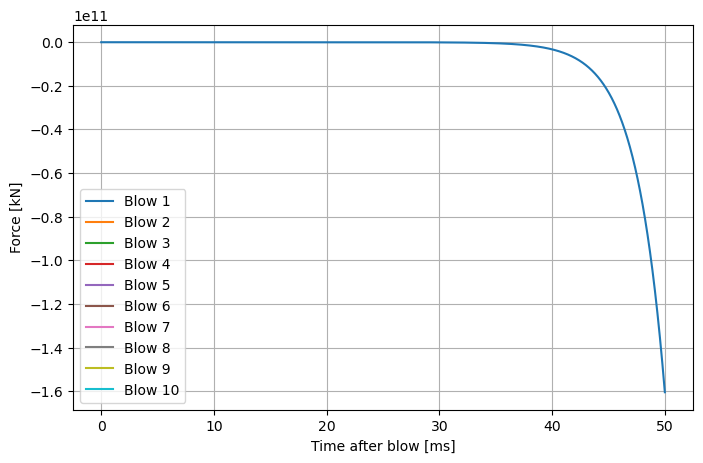

In [22]:
qc1 = 10 # MPa
qc2 = 30 # MPa 
# Qs_max1 = 0.005*qc1*np.pi*(0.5)*7*1e3  # alpha_s * qc * area [kN]
# Qs_max2 = 0.005*qc2*np.pi*(0.5)*7*1e3


# Soil profile
layers = [
    SoilLayer(top=0.0, bottom=-7.0, qb_max=5e6, qs_max=100e3, base_damping = 0.50, shaft_damping=0.16, base_quake = 0.5/60, shaft_quake=2.5e-3),     # loose sand
    SoilLayer(top=-7.0, bottom=-50.0, qb_max=10e6, qs_max=300e3, base_damping = 0.50, shaft_damping=0.16, base_quake = 0.5/120, shaft_quake=2.5e-3),    # dense sand
]
profile = SoilProfile(layers)

# Pile + Hammer
pile = Pile(length=20.0, diameter=0.5, bottom_elevation=-10.0, n_increments=10,
            youngs_modulus=35e9, damping_ratio=0.05, material_density=2400,
            soil_profile=profile)

hammer = HAMMER(mass=3000, efficiency=0.9, E_rated=5e6,
                cushion_stiffness=5e6, cushion_damping=0.15, cushion_quake=0.01)

# Run simulation
simulate_drive(pile, hammer, n_blows=10, dt=1e-5, t_per_blow=0.05, rest_time=2)

# Plot results
plot_response(pile)
plot_blow_counts(pile)
plot_blow_forces(pile)



# Points of improvement
This is only a simple model of course, but there's some ways of improving it.

- Model non-linear springs for cushions 